<a href="https://colab.research.google.com/github/Orangefox76200/CapsNet-LSTM/blob/main/CapsNet_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CapsNet_LSTM: Using real world data (DJIA Index)

DJIA Index dataset contains data of the daily DJIA Index price recorded from Jan 1st, 2010 to Dec 31st, 2019. In addition to be using Tensorflow's layers for processing sequence data such as LSTMs we will also use Capsule Network to improve the model's performance.

Let's get started!

In [9]:
import tensorflow as tf
from keras import backend as K
from keras import initializers, layers, models, optimizers

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from PIL import Image
from dataclasses import dataclass

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [12]:
from google.colab import drive
drive.mount ('gdrive')
DJIA_raw = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/DJIA.xlsx')
DJIA_raw

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


,Date,Open,High,Low,Close,Volume
0,"Jan 04, 2010",10430.69,10604.97,10430.69,10583.96,179780000
1,"Jan 05, 2010",10584.56,10584.56,10522.52,10572.02,188540000
2,"Jan 06, 2010",10564.72,10594.99,10546.55,10573.68,186040000
3,"Jan 07, 2010",10571.11,10612.37,10505.21,10606.86,217390000
4,"Jan 08, 2010",10606.40,10619.40,10554.33,10618.19,172710000
...,...,...,...,...,...,...
2511,"Dec 24, 2019",28572.57,28576.80,28503.21,28515.45,86150000
2512,"Dec 26, 2019",28539.46,28624.10,28535.15,28621.39,155970000
2513,"Dec 27, 2019",28675.34,28701.66,28608.98,28645.26,182280000
2514,"Dec 30, 2019",28654.76,28664.69,28428.98,28462.14,181600000


In [21]:
series = DJIA_raw.iloc[:,4]

In [22]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series

In [20]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use your function to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

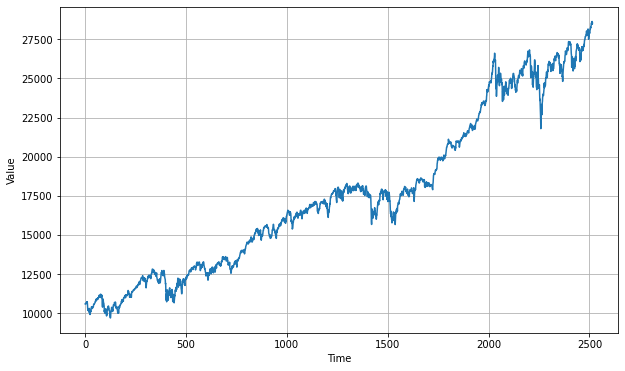

In [23]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = int((len(series)-150)*0.8)
    WINDOW_SIZE = 250
    BATCH_SIZE = 50
    SHUFFLE_BUFFER_SIZE = 2000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

The `train_val_split` and `windowed_dataset` functions:

In [24]:
def train_val_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:-150]
    series_valid = series[time_step:-150]
    time_test = time[-150:]
    series_test = series[-150:]

    return time_train, series_train, time_valid, series_valid, time_test, series_test


# Split the dataset
time_train, series_train, time_valid, series_valid, time_test, series_test = train_val_test_split(G.TIME, G.SERIES)

min-max normalization

In [25]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [26]:
series_norm = min_max_normalization(G.SERIES)

In [27]:
series_train_norm = series_norm[:G.SPLIT_TIME]
series_valid_norm = series_norm[G.SPLIT_TIME:-150]
series_test_norm = series_norm[-150:]

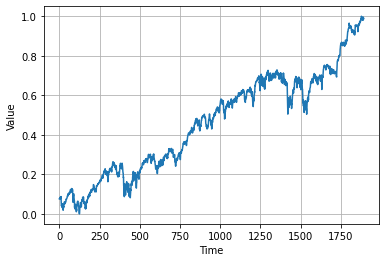

In [28]:
plot_series(time_train, series_train_norm)

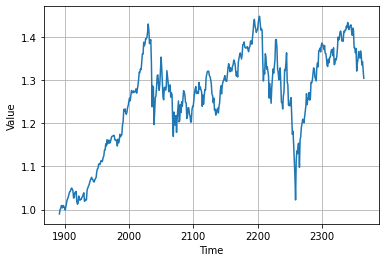

In [29]:
plot_series(time_valid, series_valid_norm)

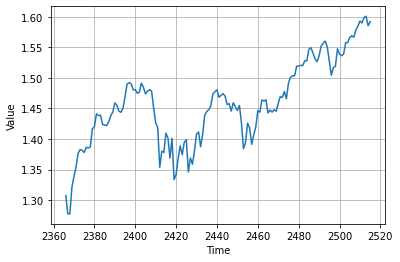

In [30]:
plot_series(time_test, series_test_norm)

In [31]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train_norm, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [32]:
val_set = windowed_dataset(series_norm[G.SPLIT_TIME-G.WINDOW_SIZE:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

LSTM and CNN-LSTM Forecasts

As baselines, we do a LSTM forecast and a CNN-LSTM forecast.

## Defining the model architecture (LSTM, CNN-LSTM, and CapsNet-LSTM)


In [46]:
def create_uncompiled_LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(30, activation="relu"),
          tf.keras.layers.Dense(10, activation="relu"),
          tf.keras.layers.Dense(1)
    ])
    model.summary()

    return model

In [47]:
def create_uncompiled_CNN_LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=512, kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(200),
          tf.keras.layers.Dense(30, activation="relu"),
          tf.keras.layers.Dense(10, activation="relu"),
          tf.keras.layers.Dense(1)
    ])
    model.summary()

    return model

In [36]:
# Test the uncompiled LSTM
uncompiled_LSTM = create_uncompiled_LSTM()

try:
    uncompiled_LSTM.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_3 (Dense)             (None, 30)                6030      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 167,951
Trainable params: 167,951
Non-trainable params: 0
_________________________________________________________________
Your current architecture is compatible with the windowed dataset! :)


In [45]:
# Test the uncompiled CNN-CNN_LSTM
uncompiled_CNN_LSTM = create_uncompiled_CNN_LSTM()

try:
    uncompiled_CNN_LSTM.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

NameError: ignored

## Adjusting the learning rate

We can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [39]:
def adjust_learning_rate_LSTM(dataset):
    
    model = create_uncompiled_LSTM()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
        
    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum = 0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
   
    history = model.fit(dataset, epochs=140, callbacks=[lr_schedule])
    
    return history

In [40]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate_LSTM(train_set)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               161600    
                                                                 
 dense_9 (Dense)             (None, 30)                6030      
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 167,951
Trainable params: 167,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/140
33/33 [==============================] - 4s 21ms/step - loss: 0.1723 - mae: 0.5371 - lr: 1.0000e-06
Epoch 2/140
33/33 [==============================] - 1s 33ms/step - 

(1e-06, 10.0, 0.0, 0.0005)

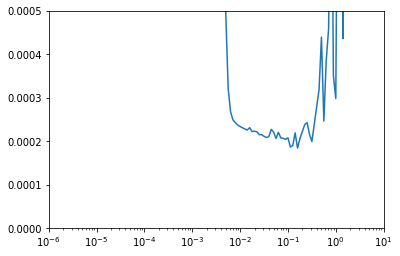

In [42]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 10, 0, 0.0005])

First, we generate a val_set which are data windows and labels that our model can accept. We reuse the windowed_dataset function for that and we pass in the x_valid points to generate the windows.

We then do the same training as before but pass in the val_set to the validation_data parameter of the fit() method.

## Compiling the model
Now that we have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series.

In [43]:
def create_LSTM():

    
    model = create_uncompiled_LSTM()

    optimizer = tf.keras.optimizers.SGD(learning_rate = 8e-2, momentum = 0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"])   

    return model

In [49]:

# Save an instance of the model
LSTM = create_LSTM()

# Train it
LSTM_history = LSTM.fit(train_set, epochs=200, validation_data = val_set)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 200)               161600    
                                                                 
 dense_15 (Dense)            (None, 30)                6030      
                                                                 
 dense_16 (Dense)            (None, 10)                310       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 167,951
Trainable params: 167,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
33/33 [==============================] - 3s 39ms/step - loss: 0.0420 - mae: 0.2343 - val_loss: 0.2983 - val_mae: 0.7645
Epoch 2/200
33/33 [=============================

training curve

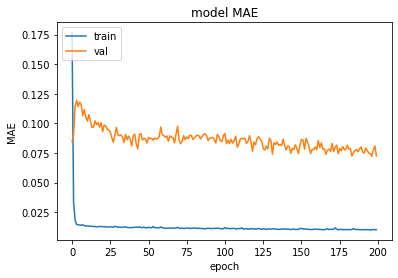

In [ ]:
plt.plot(LSTM_history.history['mae'])
plt.plot(LSTM_history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Train using train set and validation set together

In [ ]:
final_LSTM = create_LSTM()
train_val_set = windowed_dataset(series_norm[0:-150], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)
# Train it
LSTM_history = final_LSTM.fit(train_val_set, epochs=200)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 250, 512)          1536      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 250, 512)         0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 200)               570400    
                                                                 
 dense_9 (Dense)             (None, 30)                6030      
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                      

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [ ]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. Remember that this faster approach uses batches of data. 

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:

**Note:** Don't modify the cell below. 

The grader uses the same slicing to get the forecast so if you change the cell below you risk having issues when submitting your model for grading.

In [ ]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

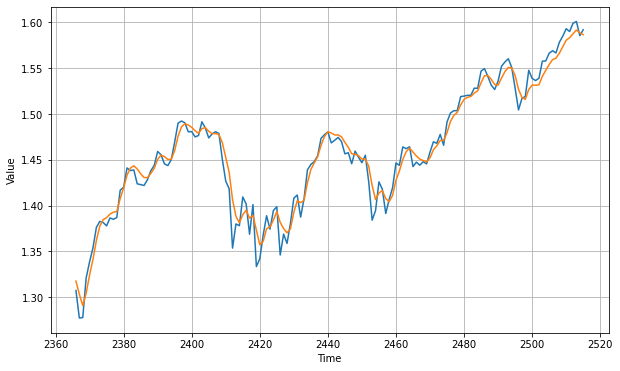

In [ ]:
# Compute the forecast for all the series
cnn_lstm_forecast = model_forecast(final_model, series_norm, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
series_test_hat = cnn_lstm_forecast[-150:]
# reverse normalization
# series_test_hat = reverse_normalization(cnn_lstm_forecast)

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test_norm)
plot_series(time_test, series_test_hat)

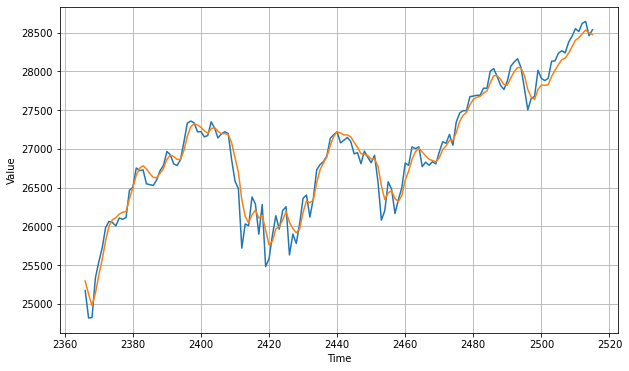

In [ ]:
series_test_hat = reverse_normalization(series_test_hat)


# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, series_test_hat)

In [ ]:
print(tf.keras.metrics.mean_squared_error(series_test, series_test_hat).numpy())
print(tf.keras.metrics.mean_absolute_error(series_test, series_test_hat).numpy())

19441.139
104.655846


In [ ]:
mse, mae = compute_metrics(series_test, series_test_hat)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the model in a HDF5 file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy SavedModel directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**